In [274]:
#Importing the libraries and packages
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from xgboost import plot_importance
import numpy as np
import sklearn as sk
import imblearn
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import sklearn.datasets as datasets
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from numpy import argmax 
from lightgbm import early_stopping
import copy
from xgboost import XGBClassifier
import xgboost as xgb

# We start the data reading and data processing

In [275]:
#Reading data from data file

df = pd.read_csv("data.csv")
# df.head()     # Checking the entries
# df.shape      #Getting the data on number of entries
# df.Lowest_distortion.value_counts()

In [276]:
#We removed all the theoretically non-exhisting molecules 
# Here we removed entries that had no structure label or data on valence electrons.

df.drop(df.index[(df["Lowest_distortion"] == "-")],axis=0,inplace=True)     
df.drop(df.index[(df["Valence_B"] == "5")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "5")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_B"] == "4")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "4")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "element not in BV")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_B"] == "element not in BV")],axis=0,inplace=True)
df.drop(df.index[(df["Vacancy_energy_eV_per_O_atom"] == "-")],axis=0,inplace=True)

# df.Lowest_distortion.value_counts()

In [277]:
# Replacing Strings with integers so that we dont encounter errors in smote
# print(df)


df['Valence_A'] = df['Valence_A'].replace(['not balanced'], '0')    #Replacing not balanced with 0
df['Valence_A'] = df['Valence_A'].replace(['3'], '1')               #Replacing 3 with 1
df['Valence_B'] = df['Valence_B'].replace(['not balanced'], '0')    #Replacing not balanced with 0
df['Valence_B'] = df['Valence_B'].replace(['3'], '1')               #Replacing 3 with 1



df['Lowest_distortion'] = df['Lowest_distortion'].replace(['cubic'], '0')        #Replacing cubic-0,orthorhombic-1,rhombohedral-2,tetragonal-3
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['orthorhombic'], '1')
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['rhombohedral'], '2')
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['tetragonal'], '3')
df['Magnetic_moment_mu_B'] = df['Magnetic_moment_mu_B'].replace(['-'], '0.00')

df['In_literature'] = df['In_literature'].replace([False], '0')   #Replacing False with 0
df['In_literature'] = df['In_literature'].replace([True], '1')    #Replacing True with 1

# print(df)
df[1:]

,Chemical_formula,A,B,In_literature,Valence_A,Valence_B,Radius_A_angs,Radius_B_angs,Lowest_distortion,Formation_energy_eVperatom,...,Magnetic_moment_mu_B,Volume_per_atom_A_cube_per_atom,Band_gap_eV,a_angs,b_angs,c_angs,alpha_deg,beta_deg,gamma_deg,Vacancy_energy_eV_per_O_atom
75,AgAlO3,Ag,Al,0,0,0,1.28,0.54,1,-1.510,...,0.00,9.898,0.000,5.094,5.323,7.300,90.0,90.0,90.0,-1.341
78,AgBO3,Ag,B,0,1,1,0.75,0.27,0,-0.350,...,0.00,8.138,0.000,3.439,3.439,3.439,90.0,90.0,90.0,-2.641
79,AgBaO3,Ag,Ba,0,0,0,1.28,1.35,1,-0.989,...,0.00,15.631,0.247,6.636,6.739,6.990,90.0,90.0,90.0,-6.975
80,AgBeO3,Ag,Be,0,0,0,1.28,0.45,0,-0.616,...,0.00,8.781,0.000,3.528,3.528,3.528,90.0,90.0,90.0,-3.058
82,AgCaO3,Ag,Ca,0,0,0,1.28,1.00,2,-0.975,...,0.00,14.204,0.000,5.884,5.884,5.884,59.4,59.4,59.4,-6.108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,ZrTmO3,Zr,Tm,0,0,0,0.89,0.96,0,-2.315,...,0.200,14.496,0.000,4.169,4.169,4.169,90.0,90.0,90.0,-3.645
5325,ZrYO3,Zr,Y,0,0,0,0.89,0.90,0,-2.126,...,0.200,15.277,0.000,4.243,4.243,4.243,90.0,90.0,90.0,-4.920
5326,ZrYbO3,Zr,Yb,0,0,0,0.89,0.95,1,-3.455,...,0.000,13.136,4.007,5.558,5.726,8.254,90.0,90.0,90.0,-6.177
5327,ZrZnO3,Zr,Zn,0,0,0,0.89,0.74,0,-1.630,...,0.001,10.804,0.000,3.780,3.780,3.780,90.0,90.0,90.0,-0.762


In [278]:
#Swapping labels for simplicity.
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
df = df_column_switch(df, "Lowest_distortion", "Vacancy_energy_eV_per_O_atom")
# df.head()

In [279]:
training_data = df.sample(frac=0.8, random_state=25)   #Distributing data set into training and testing dataset
testing_data = df.drop(training_data.index)            # Getting the testing data from dataframe


train_data = training_data.values
X_train = train_data[:, 3:20]
Y_train = train_data[:,20]
# print(X_train)
# print(Y_train)
# print(len(Y_train))
# print(len(X_train))

test_data = testing_data.values
X_test = test_data[:, 3:20]
Y_test = test_data[:,20]
print(Y_train)
# X_test.shape
# Y_test.shape
# X_test.shape

['0' '0' '0' ... '0' '0' '0']


# Applying SMOTE here

Class=0, n=1279 (60.587%)
Class=1, n=688 (32.591%)
Class=2, n=100 (4.737%)
Class=3, n=44 (2.084%)


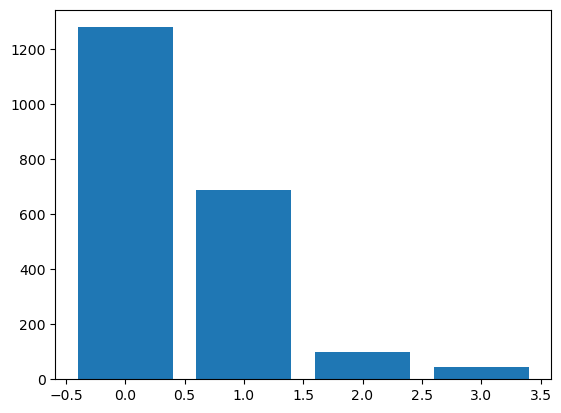

Class=0, n=1279 (25.000%)
Class=1, n=1279 (25.000%)
Class=2, n=1279 (25.000%)
Class=3, n=1279 (25.000%)


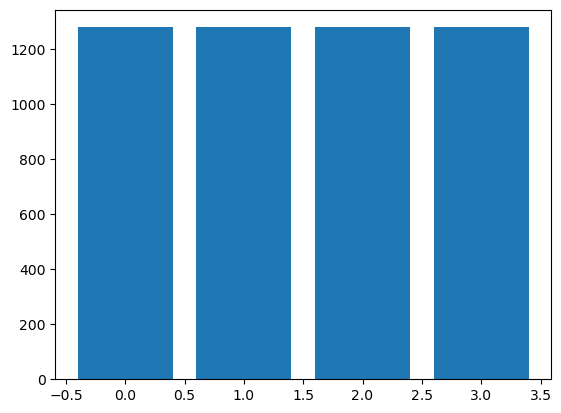

In [280]:
Y_train = LabelEncoder().fit_transform(Y_train)
#Applying SMOTE

# print(len(X_train))
#Showing data imbalance
# print(Y_train)
counter = Counter(Y_train)
for k,v in counter.items():
 per = v / len(Y_train) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


#Applying SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)


# Summarize distribution after SMOTE
counter = Counter(Y_train)
for k,v in counter.items():
 per = v / len(Y_train) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# print(X_test)
#Here we oversampled the data with SMOTE ignoring the first 3 columns as they are not important.

# Validation and parameter tuning.

In [281]:
# 'num_leaves': 2

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 2,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.33638
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.28881
[3]	valid_0's multi_logloss: 1.24395
[4]	valid_0's multi_logloss: 1.20155
[5]	valid_0's multi_logloss: 1.16139
[6]	valid_0's multi_logloss: 1.12311
[7]	valid_0's multi_logloss: 1.08679
[8]	valid_0's multi_logloss: 1.05223
[9]	valid_0's multi_logloss: 1.01928
[10]	valid_0's multi_logloss: 0.987828
[11]	valid_0's multi_logloss: 0.957514
[12]	valid

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [282]:
# 'num_leaves': 3

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 3,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.33112
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27816
[3]	valid_0's multi_logloss: 1.22845
[4]	valid_0's multi_logloss: 1.18165
[5]	valid_0's multi_logloss: 1.1375
[6]	valid_0's multi_logloss: 1.09576
[7]	valid_0's multi_logloss: 1.05617
[8]	valid_0's multi_logloss: 1.0186
[9]	valid_0's multi_logloss: 0.98291
[10]	valid_0's multi_logloss: 0.948661
[11]	valid_0's multi_logloss: 0.915442
[12]	valid_0

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [283]:
# 'num_leaves': 4

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 4,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.33056
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27765
[3]	valid_0's multi_logloss: 1.22759
[4]	valid_0's multi_logloss: 1.18046
[5]	valid_0's multi_logloss: 1.13605
[6]	valid_0's multi_logloss: 1.09399
[7]	valid_0's multi_logloss: 1.0542
[8]	valid_0's multi_logloss: 1.01635
[9]	valid_0's multi_logloss: 0.98038
[10]	valid_0's

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [284]:
# 'num_leaves': 5

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 5,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.3294
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27543
[3]	valid_0's multi_logloss: 1.22483
[4]	valid_0's multi_logloss: 1.1772
[5]	valid_0's multi_logloss: 1.1323
[6]	valid_0's multi_logloss: 1.08981
[7]	valid_0's multi_logloss: 1.0496
[8]	valid_0's multi_logloss: 1.01138
[9]	valid_0's multi_logloss: 0.975048
[10]	valid_0's m

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [285]:
# 'num_leaves': 6

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 6,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.32916
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27491
[3]	valid_0's multi_logloss: 1.22406
[4]	valid_0's multi_logloss: 1.17625
[5]	valid_0's multi_logloss: 1.13113
[6]	valid_0's multi_logloss: 1.08849
[7]	valid_0's multi_logloss: 1.04816
[8]	valid_0's multi_logloss: 1.00976
[9]	valid_0's multi_logloss: 0.97326
[10]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [286]:
# 'num_leaves': 7

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.32912
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27481
[3]	valid_0's multi_logloss: 1.22391
[4]	valid_0's multi_logloss: 1.17606
[5]	valid_0's multi_logloss: 1.13086
[6]	valid_0's multi_logloss: 1.0882
[7]	valid_0's multi_logloss: 1.04781
[8]	valid_0's multi_logl

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.77%


In [287]:
# 'num_leaves': 8

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 8,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.32906
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27469
[3]	valid_0's multi_logloss: 1.22373
[4]	valid_0's multi_logloss: 1.17583
[5]	valid_0's multi_logloss: 1.13057
[6]	valid_0's multi_logloss: 1.08786
[7]	valid_0's multi_logloss: 1.04742
[8]	valid_0's multi_logloss: 1.00889
[9]	valid_0's multi_logloss: 0.972248
[10]	valid_0

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.0636194
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0636194
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 311   0   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.84%


In [288]:
# 'num_leaves': 9

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 9,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.32896
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27448
[3]	valid_0's multi_logloss: 1.22344
[4]	valid_0's multi_logloss: 1.17545
[5]	valid_0's multi_logloss: 1.13011
[6]	valid_0's multi_logloss: 1.08732
[7]	valid_0's multi_logloss: 1.04681
[8]	valid_0's multi_logloss: 1.00821
[9]	valid_0's multi_logloss: 0.971501
[10]	valid_0

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[92]	valid_0's multi_logloss: 0.0781358
[93]	valid_0's multi_logloss: 0.0760271
[94]	valid_0's multi_logloss: 0.0739918
[95]	valid_0's multi_logloss: 0.07201
[96]	valid_0's multi_logloss: 0.0700924
[97]	valid_0's multi_logloss: 0.0682299
[98]	valid_0's multi_logloss: 0.0664326
[99]	valid_0's multi_logloss: 0.0646834
[100]	valid_0's multi_logloss: 0.0629887
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0629887
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 311   0   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.84%


# Running differerent models, we find that the best accuracy was obtained for num_leaves = 7

In [289]:
# 'learning_rate': 0.01

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.01,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.35795
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.32973
[3]	valid_0's multi_logloss: 1.30241
[4]	valid_0's multi_logloss: 1.27599
[5]	valid_0's multi_logloss: 1.25037
[6]	valid_0's multi_logloss: 1.22555
[7]	valid_0's multi_logloss: 1.20145
[8]	valid_0's multi_logloss: 1.17801
[9]	valid_0's multi_logloss: 1.15524
[10]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.98      1.00      0.99       327

    accuracy                           0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

[[333   0   0   6]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.45%


In [290]:
# 'learning_rate': 0.02

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.32912
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27481
[3]	valid_0's multi_logloss: 1.22391
[4]	valid_0's multi_logloss: 1.17606
[5]	valid_0's multi_logloss: 1.13086
[6]	valid_0's multi_logloss: 1.0882
[7]	valid_0's multi_logloss: 1.04781
[8]	valid_0's multi_logloss: 1.00934
[9]	valid_0's multi_logloss: 0.972747
[10]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.77%


In [291]:
# 'learning_rate': 0.03

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.03,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.30059
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.22233
[3]	valid_0's multi_logloss: 1.15099
[4]	valid_0's multi_logloss: 1.08574
[5]	valid_0's multi_logloss: 1.02553
[6]	valid_0's multi_logloss: 0.969881
[7]	valid_0's multi_logloss: 0.91823
[8]	valid_0's multi_logloss: 0.870108
[9]	valid_0's multi_logloss: 0.825089
[10]	valid

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.77%


In [292]:
# 'learning_rate': 0.04

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.04,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.27238
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.17196
[3]	valid_0's multi_logloss: 1.08305
[4]	valid_0's multi_logloss: 1.00359
[5]	valid_0's multi_logloss: 0.931839
[6]	valid_0's multi_logloss: 0.866892
[7]	valid_0's multi_logloss: 0.807509
[8]	valid_0's multi_logloss: 0.753193
[9]	valid_0's multi_logloss: 0.703393
[10]	val

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 311   0   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.84%


In [293]:
# 'learning_rate': 0.05

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.24448
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.12371
[3]	valid_0's multi_logloss: 1.01962
[4]	valid_0's multi_logloss: 0.928671
[5]	valid_0's multi_logloss: 0.848212
[6]	valid_0's multi_logloss: 0.776387
[7]	valid_0's multi_logloss: 0.712134
[8]	valid_0's multi_logloss: 0.654342
[9]	valid_0's multi_logloss: 0.602131
[10]	va

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 311   0   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.84%


In [294]:
# 'learning_rate': 0.08

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.08,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.16272
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 0.990823
[3]	valid_0's multi_logloss: 0.852919
[4]	valid_0's multi_logloss: 0.739257
[5]	valid_0's multi_logloss: 0.644211
[6]	valid_0's multi_logloss: 0.56376
[7]	valid_0's multi_logloss: 0.495138
[8]	valid_0's mult

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.99      1.00      1.00       327

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

[[337   0   0   2]
 [  0 311   0   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.84%


In [295]:
# 'learning_rate': 0.002

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.002,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.38122
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.3754
[3]	valid_0's multi_logloss: 1.36962
[4]	valid_0's multi_logloss: 1.36389
[5]	valid_0's multi_logloss: 1.35819
[6]	valid_0's multi_logloss: 1.35253
[7]	valid_0's multi_logloss: 1.3469
[8]	valid_0's multi_logloss: 1.34131
[9]	valid_0's multi_logloss: 1.33576
[10]	valid_0's 

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 0.943303
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.943303
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       339
           1       1.00      1.00      1.00       311
           2       0.97      1.00      0.99       302
           3       0.98      0.98      0.98       327

    accuracy                           0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

[[329   0   3   7]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   1   4 322]]
Accuracy: 98.75%


In [296]:
# 'learning_rate': 0.008

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.008,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.36375
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.341
[3]	valid_0's multi_logloss: 1.31884
[4]	valid_0's multi_logloss: 1.29727
[5]	valid_0's multi_logloss: 1.27624
[6]	valid_0's multi_logloss: 1.25574
[7]	valid_0's multi_logloss: 1.23574
[8]	valid_0's multi_logloss: 1.21618
[9]	valid_0's multi_logloss: 1.19707
[10]	valid_0's 

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.98      1.00      0.99       327

    accuracy                           0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

[[332   1   0   6]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.37%


In [297]:
# 'learning_rate': 0.009

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.009,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4100
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 17
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.36084
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.33535
[3]	valid_0's multi_logloss: 1.3106
[4]	valid_0's multi_logloss: 1.28657
[5]	valid_0's multi_logloss: 1.26322
[6]	valid_0's multi_logloss: 1.24052
[7]	valid_0's multi_logloss: 1.21843
[8]	valid_0's multi_logloss: 1.19689
[9]	valid_0's multi_logloss: 1.1759
[10]	valid_0's 

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       339
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       302
           3       0.98      1.00      0.99       327

    accuracy                           0.99      1279
   macro avg       0.99      0.99      0.99      1279
weighted avg       0.99      0.99      0.99      1279

[[332   1   0   6]
 [  0 310   1   0]
 [  0   0 302   0]
 [  0   0   0 327]]
Accuracy: 99.37%


# We see that learning rate = 0.05 gives best accuracy and Number of leaves = 7 give best results.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

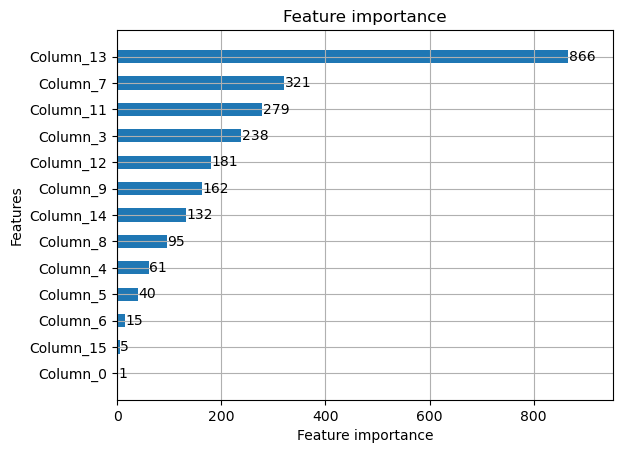

In [304]:
# Here we got importance of features owing to the data
lgb.plot_importance(model, height=.5)

# Implementing LBGM

In [190]:
Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'num_class': 4
} 


# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Y_pred = model.predict(X_test)

Y_pred = argmax(Y_pred, axis=1)
cr = classification_report(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 909, number of used features: 17
[LightGBM] [Info] Start training from score -1.387395
[LightGBM] [Info] Start training from score -1.400699
[LightGBM] [Info] Start training from score -1.470011
[LightGBM] [Info] Start training from score -1.294892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's multi_logloss: 1.25413
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.13555
[3]	valid_0's multi_logloss: 1.03346
[4]	valid_0's multi_logloss: 0.944058
[5]	valid_0's multi_logloss: 0.865496
[6]	valid_0's multi_logloss: 0.795786
[7]	valid_0's multi_logloss: 0.73293
[8]	valid_0's multi_

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


# XGBoost

In [253]:
# Validation and tuning

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 10
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 98.25%


In [254]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 15
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 98.68%


In [255]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.12%


In [256]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 25
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.12%


In [257]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 30
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.56%


In [233]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 35
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.56%


In [234]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 40
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.56%


# Epoch = 15 gives best accuracy

In [235]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 2,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 98.68%


In [236]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 1,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 98.25%


In [237]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 5,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.12%


In [238]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 4,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

228
228
Accuracy: 99.12%


# Max_depth = 2 gives the best accuracy

In [258]:
train = xgb.DMatrix(X_train, label = Y_train)
test = xgb.DMatrix(X_test, label = Y_test)

# specify hyperparameters
params = {
    'max_depth': 2,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.48%
